# OISSTv2 Live Updating Workflow

This notebook is for documenting the steps to build a single annual OISSTv2 file using update caches. The processing of global anomalies, and the regional timelines that we keep on hand for analyses. 

The steps were developed initially in `Update_01_Download_OISST` then the steps were abstracted into functions and placed into the `oisstools.py` module. This notebook will follow the same steps but with much less code, hopefully with less room for error.

**EDIT:**
This notebook exists to document the processing steps, but the ultimate goal would be to replace this notebook with script workflows using prefect in `oisst_prefect.py`. Use this notebook for debugging or extending the workflow, then transfer to `oisst_prefect.py`

In [1]:
# Libraries
from bs4 import BeautifulSoup
# import requests
import os
import xarray as xr
import datetime
import oisstools as ot


#### 1. Set workspace
workspace = "local"
box_root = ot.set_workspace("local")
_cache_root = ot.set_cache_root(box_root)


#### 2. What Months are we checking?
this_month = ot.get_update_month(return_this_month = True)
last_month = ot.get_update_month(return_this_month = False)
update_yr  = ot.check_update_yr(for_this_month = True)

# ### Manual Month/Year Selection
# last_month = "11"
# this_month = "12"
# update_yr = "2024"


# Specify year range to update for anomaly timeseries
yr_min = update_yr
yr_max = update_yr


# variable name to mask and make timeline from
var_name = "sst"


#### 3. Print Last Update
print(f"Working via directory at: {box_root}")
print(f"Updated using months:     {last_month} & {this_month}, Year: {update_yr}")
print(f"Updating Year(s):         {yr_min} - {yr_max}")

# Check that the root directory isn't broken
os. listdir('/Users/akemberling/Library/CloudStorage/') 

Working via directory at: /Users/akemberling/Library/CloudStorage/Box-Box/
Updated using months:     01 & 02, Year: 2024
Updating Year(s):         2024 - 2024


['.DS_Store', 'Box-Box']

## 1. Download Daily Files for Last Month

The first step in the process is to hit the NCEI data catalog and download all daily `.nc` files for the previous month. If the current month is January this will not run, returning a message. Files in the data catalog have text prefixes indicating whether or not the data is preliminary or not, the cache function will note all files cached, whether or not preliminary files were included, and whether preliminary files were deleted now that their finalized data has become available.

In [2]:
# Use cache_oisst function to update cache for last month
if last_month != "12":
    ot.cache_oisst(
        # cache_month = "11", 
        # update_yr = "2023",
        cache_month = last_month, 
        update_yr = update_yr, 
        workspace = workspace, 
        verbose = True)
else:
    print("Last month not updated because of year transition")    

Caching Daily NETCDF File: oisst-avhrr-v02r01.20240101.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240102.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240103.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240104.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240105.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240106.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240107.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240108.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240109.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240110.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240111.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240112.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240113.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240114.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240115.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240116.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240117_preliminary.nc
Ca

## 2. Download Daily Files for This Month

The second step repeats the exact process as step 1., but for the current month. There is no issue of overlapping years so there is no check against whether or not it is January etc. this time.

In [3]:
# Use cache_oisst function to update cache for current month
ot.cache_oisst(
    # cache_month = "01", 
    # update_yr = "2023",
    cache_month = this_month,
    update_yr = update_yr, 
    workspace = workspace, 
    verbose = True)

Caching Daily NETCDF File: oisst-avhrr-v02r01.20240101.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240102.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240103.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240104.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240105.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240106.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240107.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240108.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240109.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240110.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240111.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240112.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240113.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240114.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240115.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240116.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20240117_preliminary.nc
Ca

## 3. Build Annual File

This step takes the daily cache files that have been incrementally added throughout the year, and appends them into a single yearly `.nc` file.

In [5]:
# Assemble the annual file
oisst_update = ot.build_annual_from_cache(
    update_yr = update_yr,
    last_month = last_month, 
    this_month = this_month, 
    workspace = workspace, 
    verbose = True)
print(f"Updating Annual File for {update_yr} at: {datetime.datetime.now()}")

TypeError: unsupported operand type(s) for -: 'str' and 'int'

## 4. Export Update

In this step the annual file is saved back to box, replacing/updating the global annual file.

In [5]:
# export update using same file pattern as everything else
ot.export_annual_update(
    cache_root   = _cache_root,
    update_yr    = update_yr,
    oisst_update = oisst_update)
print(f"Saving Annual File for {update_yr} at: {datetime.datetime.now()}")

File Saved to /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.2023.v2.nc
Saving Annual File for 2023 at: 2024-01-16 13:15:09.577496


## 5. Check Annual file

This next step is just a visual check of the full timeseries to see what dates have been included and to visualize those trends.

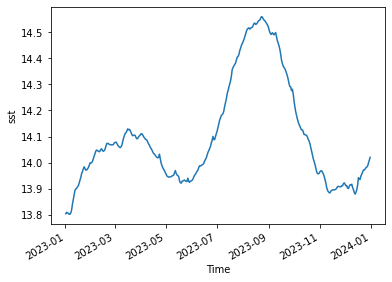

In [6]:
# Close to see if the saving is working
oisst_update.close()

# load from where update is saved 
oisst_update = ot.load_box_oisst(
    box_root = box_root, 
    start_yr = update_yr, 
    end_yr = update_yr, 
    anomalies = False, 
    do_parallel = True
)
oisst_update.sst.mean(("lon", "lat")).plot()

## 6. Update Annual Anomalies

This step has the opportunity to update anomalies for a range of years, the default update year is the `update_yr` value set at the top of the notbeook.

The process for this step is to match the current year annual file just updated, to the 30-year climatology we have on file. The anomalies are calculated and saved as their own annual NetCDF.

## 6B. Update Anomalies for New Climatology

Beginning in 2022, the climatology used by the world meteorlogical organization transitioned from a 1982-2011 climatology to a 1991-2020 climatology. At this point we decided to maintain anomalies from the new climatology in our records rather than the former climatological reference period.

In [7]:
# # Set desired climatology period
# reference_period = "1982-2011"
# print(f"Calculating Anomalies for {reference_period} reference period.")

# # Process Global Anomalies for the select years
# ot.update_global_anomalies(
#     yr_min = yr_min, 
#     yr_max = yr_max, 
#     box_root = box_root, 
#     var_name = "sst", 
#     reference_period = reference_period)


# Set desired climatology period
reference_period = "1991-2020"
print(f"Calculating Anomalies for {reference_period} reference period.")

# Process Global Anomalies for the select years
ot.update_global_anomalies(
    yr_min = yr_min, 
    yr_max = yr_max, 
    box_root = box_root, 
    var_name = "sst", 
    reference_period = reference_period)

Calculating Anomalies for 1991-2020 reference period.
Saving anomaly year: 2023


## 7. Update Global Timeseries

This step saves the daily temperatures, climatological averages, and daily temperature anomalies for the earth as a whole in the form of a pandas dataframe.

In [8]:
# Update the timeseries of global temps/anoms
ot.update_global_timeseries(
    yr_min = yr_min, 
    yr_max = yr_max, 
    box_root = box_root, 
    var_name = "sst", 
    reference_period = "1982-2011")

Updating Global Timeseries


## 8. Regional Collections:

This point is the transition from gridded global datasets to dataframe/tabular datasets specific to different masking regions. These regions are organized by collections and processed in those groups.

The way groups are organized is detailed in the `oisstools.py`. There are lookup functions that list out where each collection of shapefiles is found, what their naming conventions are (prefixes/suffixes), and their file extensions (.shp/.geojson). 

To add a new collection these steps should be followed:
 * Place the relevant shapefiles into a single folder in the cloud storage space
 * List their names following the guide of the other groups
 * Make a matching folder for the timeseries that will live in the `oisst_mainstays/` directory
 * Run them all together using `ot.update_regional_timeseries_collection()`




### GMRI Focal Areas

At GMRI there are a handful of areas that we keep tabs on because they relate to certain datasets, or they have regional importance worth tracking. This collection includes the bounding box for the Gulf of Maine that Andy had historically used, the footprint for CPR data used as the Gulf of Maine, Long Island Sound, and also the Northwest Atlantic off the coast of Greenland.

### Northeast Trawl Survey Regions

This collection includes region designations that are aggregates of trawl survey strata. This collection includes, Gulf of Maine, Georges Bank, Southern New England, Mid-Atlantic Bight, and the whole region (excluding strata that are usually omitted from analyses i.e. inshore strata)

### Ecological Production Units

This collection includes 4 regions along the Northeast US coastal shelf that have been found to have a unique combination of oceanographic, biotic, and bathymetric features. This includes a shapefile for Gulf of Maine, Georges Bank, Scotian Shelf (within US waters only), and the Mid-Atlantic Bight

Shapefile Source: ecodata r-package

### Large Marine Ecosystems

This collection contains all large marine ecosystems: https://ioc.unesco.org/topics/large-marine-ecosystems#:~:text=Large%20marine%20ecosystems%20(LMEs)%20are,the%20major%20ocean%20current%20systems./

In [9]:
#### Update the regional timeseries groups: ####

# There is a shapely warning about multi-part polygons. This does not effect the output we care about, but is a warning about deprecated functionality and is suppressed here
import warnings
warnings.filterwarnings('ignore')


# GMRI Focal Areas
ot.update_regional_timeseries_collection(
    start_yr = yr_min, 
    end_yr = yr_max, 
    region_collection = "gmri_sst_focal_areas", 
    box_root = box_root)

# NMFS Trawl Regions
ot.update_regional_timeseries_collection(
    start_yr = yr_min, 
    end_yr = yr_max, 
    region_collection = "nmfs_trawl_regions", 
    box_root = box_root)

ot.update_regional_timeseries_collection(
    start_yr = yr_min, 
    end_yr = yr_max, 
    region_collection = "epu", 
    box_root = box_root)

# Large Marine Ecosystems
ot.update_regional_timeseries_collection(
    start_yr = yr_min, 
    end_yr = yr_max, 
    region_collection = "lme", 
    box_root = box_root)



Updating Timeseries for: gmri_sst_focal_areas
Updating Timeseries for:
 - apershing_gulf_of_maine
 - cpr_gulf_of_maine
 - aak_northwest_atlantic
 - long_island_sound
Updating Timeseries for: nmfs_trawl_regions
Updating Timeseries for:
 - georges_bank
 - gulf_of_maine
 - southern_new_england
 - mid_atlantic_bight
 - inuse_strata
 - regions_collection
Updating Timeseries for: epu
Updating Timeseries for:
 - GB
 - GOM
 - MAB
 - SS
Updating Timeseries for: lme
Updating Timeseries for:
 - agulhas_current
 - aleutian_islands
 - antarctica
 - arabian_sea
 - baltic_sea
 - barents_sea
 - bay_of_bengal
 - beaufort_sea
 - benguela_current
 - black_sea
 - california_current
 - canadian_eastern_arctic_west_greenland
 - canadian_high_arctic_north_greenland
 - canary_current
 - caribbean_sea
 - celtic_biscay_shelf
 - central_arctic
 - east_bering_sea
 - east_brazil_shelf
 - east_central_australian_shelf
 - east_china_sea
 - east_siberian_sea
 - faroe_plateau
 - greenland_sea
 - guinea_current
 - gulf

---

### MarineRegions.org Northeast US Marine Regions

I'm unsure where/when these were integrated into our shapefile collection, but they come from marineregions.org and include shapefiles for the Gulf of Maine, Georges Bank, and the Northeastern US LME. All of these include a high level of coastline detail and can be quite slow to load 
and work with.


### Gulf of Maine Physio-Regions

PhysioRegions_WGS84 represents the physiographic regions of the Gulf of Maine and the study area for the Census of Marine Life, Gulf of Maine Area program.

For a detailed description of physioregion delineation, go to http://research.usm.maine.edu/gulfofmaine-census/about-the-gulf/physical-characteristics/bathymetry/hypsometric-characterization-of-the-gulf-of-maine-georges-bank-scotian-shelf

In [14]:
# # Northeast Marine Regions
# ot.update_regional_timeseries_collection(
#     start_yr = yr_min, 
#     end_yr = yr_max, 
#     region_collection = "nelme_regions", 
#     box_root = box_root)

# # Gulf of Maine Physio Regions
# ot.update_regional_timeseries_collection(
#     start_yr = yr_min, 
#     end_yr = yr_max, 
#     region_collection = "gom_physio_regions", 
#     box_root = box_root)